### Large and small scale usage of the 2pcf seem to yield different constraints. I want to see how different.

fiducial 2215
Om_m 497
Om_p 499
h_m 500
h_p 500
ns_m 499
ns_p 499
Ob2_m 499
Ob2_p 499
s8_m 499
s8_p 499
Removed no burn in
fiducial 2100
Om_m 497
Om_p 499
h_m 500
h_p 500
ns_m 499
ns_p 499
Ob2_m 499
Ob2_p 499
s8_m 499
s8_p 499
Removed no burn in
fiducial 1560
Om_m 497
Om_p 499
h_m 500
h_p 500
ns_m 499
ns_p 499
Ob2_m 499
Ob2_p 499
s8_m 499
s8_p 499
Removed no burn in


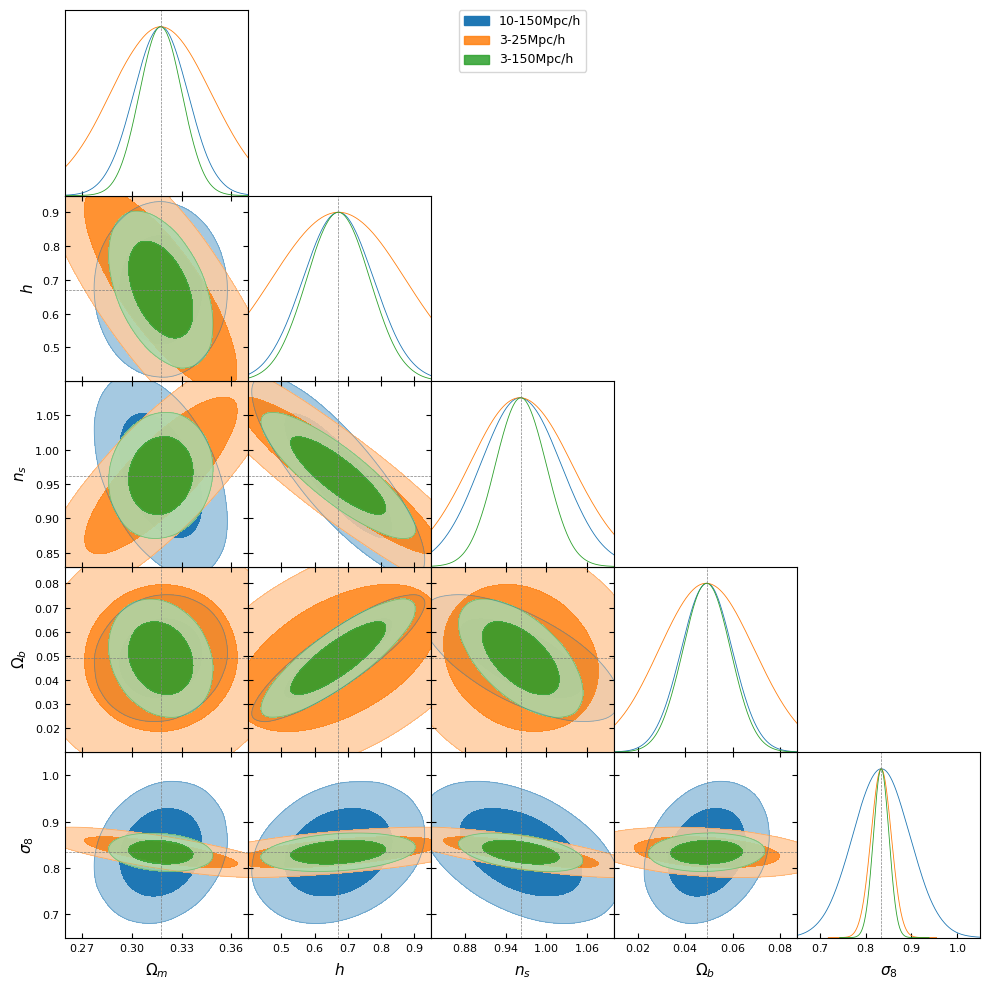

In [10]:
def get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis):
    filename = f'2pcfdata_{rmin}-{rmax}-{nbins_m}-{nbins_s}-{cosm}-{space}{axis}-*.dat'
    return filename

def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

def get_MeanCovCorrM_2pcf(cosm):

    #import file_parameters as fp

    rmin = file_parameters_2pcf['rmin']
    rmax = file_parameters_2pcf['rmax']
    nbins_s = file_parameters_2pcf['nbins_s']
    nbins_m = file_parameters_2pcf['nbins_m']
    space = file_parameters_2pcf['space']
    filedir = file_parameters_2pcf['filedir']
    axis = file_parameters_2pcf['axis']

    filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
    
    path = filedir+f'{cosm}/'+filenames

    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    xi_ls = []

    # Read all files
    for file in filelist:

        data = ascii.read(file)
        xi_ls.append( np.concatenate((data['xi0'],data['xi2']),axis=None) )

    xi_ls_array = np.array(xi_ls)
    #print(xi_ls)
    mean = np.mean(xi_ls_array, axis=0)
    covariance = np.cov(xi_ls_array.T)
    corrm = np.corrcoef(xi_ls_array.T)

    return mean, covariance, corrm


def get_derivatives(cosm_param,stat):
    
    import cosm_parameters as cp

    step = cp.cosm_param[cosm_param]['step']

    if stat=='2pcf':
        mean_m = get_MeanCovCorrM_2pcf(cosm_param+'_m')[0]
        mean_p = get_MeanCovCorrM_2pcf(cosm_param+'_p')[0]

    dChi_dtheta = (mean_p-mean_m)/(2*step)
    
    return dChi_dtheta

def get_covmatrix(summaries):
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return covariance, inverse_covariance, corrm

def get_covfactor(stat,samples):

    #import file_parameters as fp
    #import cosm_parameters as cp

    if stat=='2pcf':
        rmin = file_parameters_2pcf['rmin']
        rmax = file_parameters_2pcf['rmax']
        nbins_s = file_parameters_2pcf['nbins_s']
        nbins_m = file_parameters_2pcf['nbins_m']
        space = file_parameters_2pcf['space']
        filedir = file_parameters_2pcf['filedir']
        axis = file_parameters_2pcf['axis']
        filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,'fiducial',space,axis)
        bins = nbins_s
        #path = filedir+'fiducial/'+filenames

    path = filedir+'fiducial/'+filenames

    filelist = glob.glob(path)
    #nsim = len(filenames)
    nsim = len(filelist)
    #nsim=2100
    print('covfactor nsim:',nsim)
    nparam = len(samples)


    covfactor = (nsim-1)/(nsim-bins+nparam-1)

    return covfactor


def fisher_element(dChi_dtheta1, dChi_dtheta2, covfactor, covariance_fid):

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f


from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.io import ascii
import cosm_parameters as cp
#import file_parameters as fp

param_limits = {
    'Om':(0.26, 0.37),
    'Ob2':(0.01, 0.087),
    'h':(0.4, .95),
    's8':(0.65, 1.05),
    'ns':(0.83, 1.1),
    'Mnu':(-0.65, 0.65)
}




samples = ['Om','h','ns','Ob2','s8']
labels = [r'\Omega_m',r'h',r'n_s',r'\Omega_b',r'\sigma_8']
mean_theta = [cp.cosm_param[sample]['fid'] for sample in samples]
random_state = np.random.default_rng(10)


############################################################
#2pcf LARGE
############################################################
file_parameters_2pcf = dict(
    {   
        "nbins_s":29,  #9, 12, 29
        "nbins_m":30,  #10, 30
        "rmin":10,     #3, 10
        "rmax":150,    #25, 150
        "space":'zspace',
        "filedir":'../data/output/2pcf/',
        "axis":0
    })
# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_2pcf('fiducial')

#covfactor = get_covfactor('2pcf',samples)
covfactor = 1

#Computing derivatives and Fisher matrix
derivatives = [get_derivatives(sample,'2pcf') for sample in samples]

fisher_matrix = np.array([fisher_element(derivatives[i],derivatives[j],covfactor,covariance_fid) \
                          for i in range(len(samples)) for j in range(len(samples))]).\
                            reshape(len(samples),len(samples))

cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf_large = MCSamples(samples=samp, names=samples, labels=labels)


############################################################
#2pcf SMALL
############################################################
file_parameters_2pcf = dict(
    {   
        "nbins_s":12,  #9, 12, 29
        "nbins_m":30,  #10, 30
        "rmin":3,     #3, 10
        "rmax":25,    #25, 150
        "space":'zspace',
        "filedir":'../data/output/2pcf/',
        "axis":0
    })
# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_2pcf('fiducial')

#covfactor = get_covfactor('2pcf',samples)
covfactor = 1

#Computing derivatives and Fisher matrix
derivatives = [get_derivatives(sample,'2pcf') for sample in samples]

fisher_matrix = np.array([fisher_element(derivatives[i],derivatives[j],covfactor,covariance_fid) \
                          for i in range(len(samples)) for j in range(len(samples))]).\
                            reshape(len(samples),len(samples))

cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf_small = MCSamples(samples=samp, names=samples, labels=labels)

############################################################
#2pcf BOTH
############################################################
file_parameters_2pcf = dict(
    {   
        "nbins_s":29,  #9, 12, 29
        "nbins_m":30,  #10, 30
        "rmin":3,     #3, 10
        "rmax":150,    #25, 150
        "space":'zspace',
        "filedir":'../data/output/2pcf/',
        "axis":0
    })
# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_2pcf('fiducial')

#covfactor = get_covfactor('2pcf',samples)
covfactor = 1

#Computing derivatives and Fisher matrix
derivatives = [get_derivatives(sample,'2pcf') for sample in samples]

fisher_matrix = np.array([fisher_element(derivatives[i],derivatives[j],covfactor,covariance_fid) \
                          for i in range(len(samples)) for j in range(len(samples))]).\
                            reshape(len(samples),len(samples))

cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf_both = MCSamples(samples=samp, names=samples, labels=labels)
############################################################
# plot
############################################################

colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()



method_labels = ['10-150Mpc/h','3-25Mpc/h','3-150Mpc/h']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf_large,mcs_2pcf_small,mcs_2pcf_both], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)
g.add_param_markers({'Om':cp.cosm_param['Om']['fid'],'h':cp.cosm_param['h']['fid'],\
                     'ns':cp.cosm_param['ns']['fid'],'Ob2':cp.cosm_param['Ob2']['fid'],'s8':cp.cosm_param['s8']['fid']})

# Show the plot
plt.show()  
